In [282]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import mayavi
%matplotlib inline

In [283]:
def imshow(img):
    plt.figure(figsize = (10,10))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()

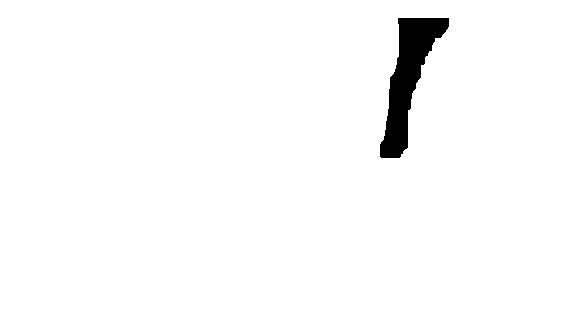

In [284]:
imgs = [
    "../data/1622821073.png", #0
    "../data/1622821834.png", #1
    "../data/1623405106.png", #2
    "../data/1623409367.png", #3
    "../data/1623421460.png"  #4
]
activeImg = imgs[4]

greyMat = cv.imread(cv.samples.findFile(activeImg))
if greyMat is None:
    sys.exit("Could not read the image.")
imshow(greyMat)

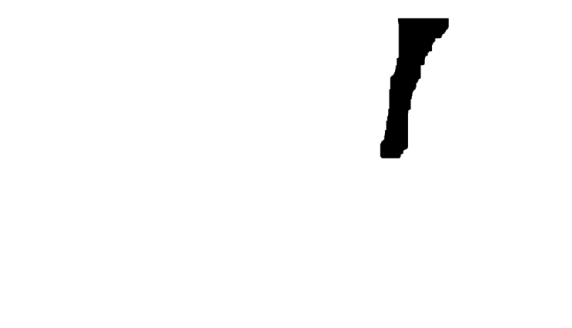

In [285]:
blurMat = cv.GaussianBlur(greyMat, (5, 5), 0)
imshow(blurMat)

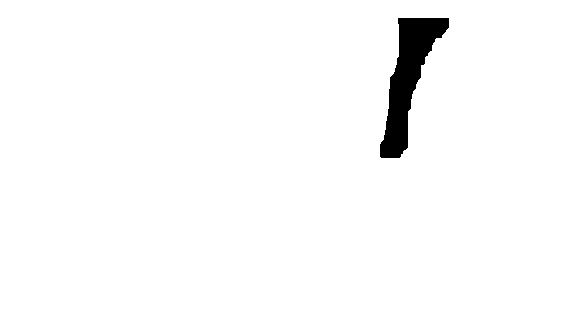

In [286]:
prop_threshold = 0.6
prop_threshold_max = 255.0
ret, threshMat = cv.threshold(blurMat, prop_threshold * 255.0, prop_threshold_max, cv.THRESH_BINARY);
imshow(threshMat)

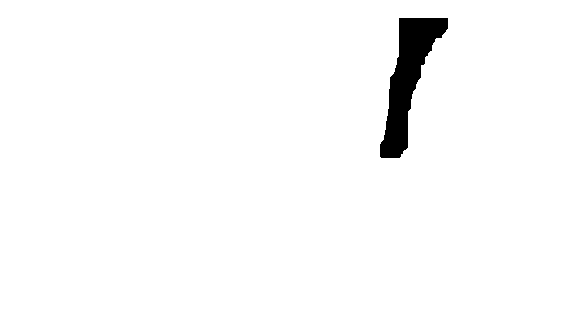

In [287]:
prop_morph_kernel = 23
morphKernel = cv.getStructuringElement(cv.MORPH_RECT, (prop_morph_kernel, prop_morph_kernel), (-1, -1));
morphMat = cv.morphologyEx(threshMat, cv.MORPH_OPEN, morphKernel);
morphMat = cv.morphologyEx(morphMat, cv.MORPH_CLOSE, morphKernel);
imshow(morphMat)

0: 919601.0 (discarded)
1: 18621.0 


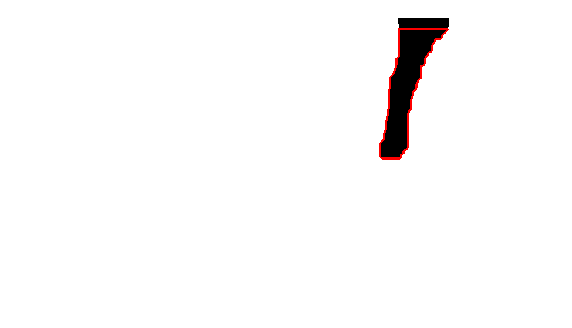

In [288]:
morphMat2 = morphMat.copy()

min_area = 25 * 25
max_area = 300 * 300

# Add white border to isolate contours from border
h, w, _ = morphMat2.shape
cv.rectangle(morphMat2, (0, 0), (w, h), (255,255,255), 100)

morphMat2 = cv.cvtColor(morphMat2, cv.COLOR_BGR2GRAY)
contours, hierarchy = cv.findContours(morphMat2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

outMat = greyMat.copy()

for i, c in enumerate(contours):
    area = cv.contourArea(c)
    discarded = True
    if area > min_area and area < max_area:
        cv.drawContours(outMat, [contours[1]], -1, (255,0,0), 3)
        discarded = False
    discardedStr = '(discarded)' if discarded else ''
    print(f'{i}: {area} {discardedStr}')
imshow(outMat)

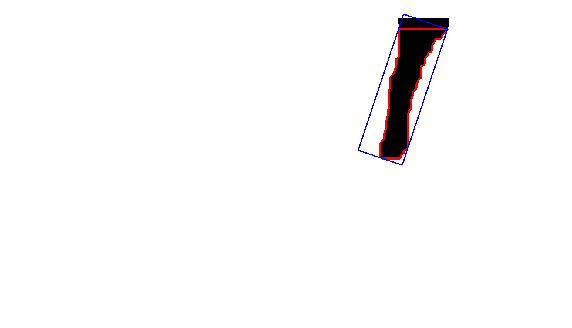

In [289]:
cnt = contours[1]
outMat2 = outMat.copy()

rect = cv.minAreaRect(cnt)
box = cv.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
box = np.int0(box)
cv.drawContours(outMat2,[box],0,(0,0,255),2)
imshow(outMat2)

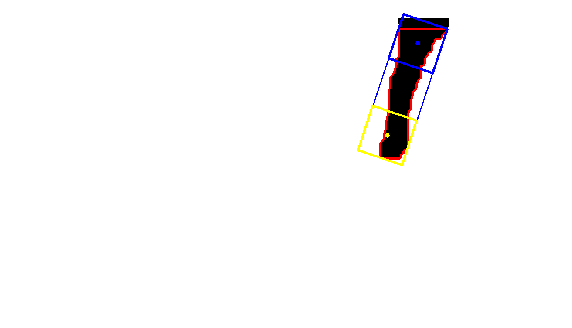

In [290]:
box2 = box
outMat3 = outMat2.copy()

sls = [ # sideLengths
    [0, np.linalg.norm(box2[0] - box2[1]), box2[0], box2[1], box2[2], box2[3]],
    [1, np.linalg.norm(box2[1] - box2[2]), box2[1], box2[2], box2[3], box2[0]],
    [2, np.linalg.norm(box2[2] - box2[3]), box2[2], box2[3], box2[0], box2[1]],
    [3, np.linalg.norm(box2[3] - box2[0]), box2[3], box2[0], box2[1], box2[2]],
]
sls = sorted(sls, key=lambda p: p[1])

rects = []
for i in range(2):
    _, length, x1, x2, x3, x4 = sls[i]
    v = x3 - x2 # direction
    v_hat = v / np.linalg.norm(v) # unit vector
    x3_new = x2 + (v_hat * length)
    x4_new = x1 + (v_hat * length)
    rect = np.int0([x1, x2, x3_new, x4_new])
    center = np.int0(x1 + ((x3_new - x1) / 2))
    rects.append([rect, center, False])

h, w, _ = outMat3.shape
img_center = np.int0([w / 2, h / 2])
r1, r2 = rects
dist2center1 = np.linalg.norm(img_center - r1[1])
dist2center2 = np.linalg.norm(img_center - r2[1])
dist2vertEdge1 = np.min([r1[1][0], w - r1[1][0]])
dist2vertEdge2 = np.min([r2[1][0], w - r2[1][0]])
dist2horizEdge1 = np.min([r1[1][1], h - r1[1][1]])
dist2horizEdge2 = np.min([r2[1][1], h - r2[1][1]])

maxCenterDist = img_center
maxVertDist = img_center[0]
maxHorizDist = img_center[1]

score1 = dist2center1 + (img_center[0] - dist2vertEdge1) + (img_center[1] - dist2horizEdge1)
score2 = dist2center2 + (img_center[0] - dist2vertEdge2) + (img_center[1] - dist2horizEdge2)
if score1 < score2:
    rects[0][2] = True
else:
    rects[1][2] = True

for i in range(2):
    color = (255,255,0) if rects[i][2] else (0, 0, 255)
    cv.drawContours(outMat3, [rects[i][0]], 0, color, 3) # draw box
    cv.circle(outMat3, tuple(rects[i][1]), 5, color, -1) # draw center
    
imshow(outMat3)